## Part 1 : A Gentle Introduction to the Spatial Join

One problem I came across when analyzing the New York City [Taxi Dataset](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml), is that from 2009 to June 2016, both the starting and stopping locations of taxi trips were given as longitude and latitude points. After July 2016, to provide a degree of anonymity when releasing data to the public, the Taxi and Limousine Commission (TLC) only provides the starting and ending "taxi zones" of a trip, and a shapefile that specifies the boundaries, [available here](https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip). Let's load this up in Geopandas, and set the coordinate system to 'epsg:4326', which is latitude and longitude coordinates.

In [123]:
# <!-- collapse=True -->
%matplotlib inline
%config InlineBackend.figure_format='retina'

import geopandas as gpd
import matplotlib
from shapely.geometry import Point
import urllib
import dask.dataframe as dd
import numpy as np

plt = matplotlib.pyplot
coord_system = {'init': 'epsg:4326'}
df = gpd.read_file('../shapefiles/taxi_zones.shp').to_crs(coord_system)
df = df.drop(['Shape_Area', 'Shape_Leng', 'OBJECTID'], axis=1)
df.head()

,LocationID,borough,geometry,zone
0,1,EWR,"POLYGON ((-74.18445299999996 40.6949959999999,...",Newark Airport
1,2,Queens,(POLYGON ((-73.82337597260663 40.6389870471767...,Jamaica Bay
2,3,Bronx,POLYGON ((-73.84792614099985 40.87134223399991...,Allerton/Pelham Gardens
3,4,Manhattan,POLYGON ((-73.97177410965318 40.72582128133705...,Alphabet City
4,5,Staten Island,POLYGON ((-74.17421738099989 40.56256808599987...,Arden Heights


The geometry column contains a set of vertices for each of the polygons (or collections of polygons) that make up the districts. Let's plot

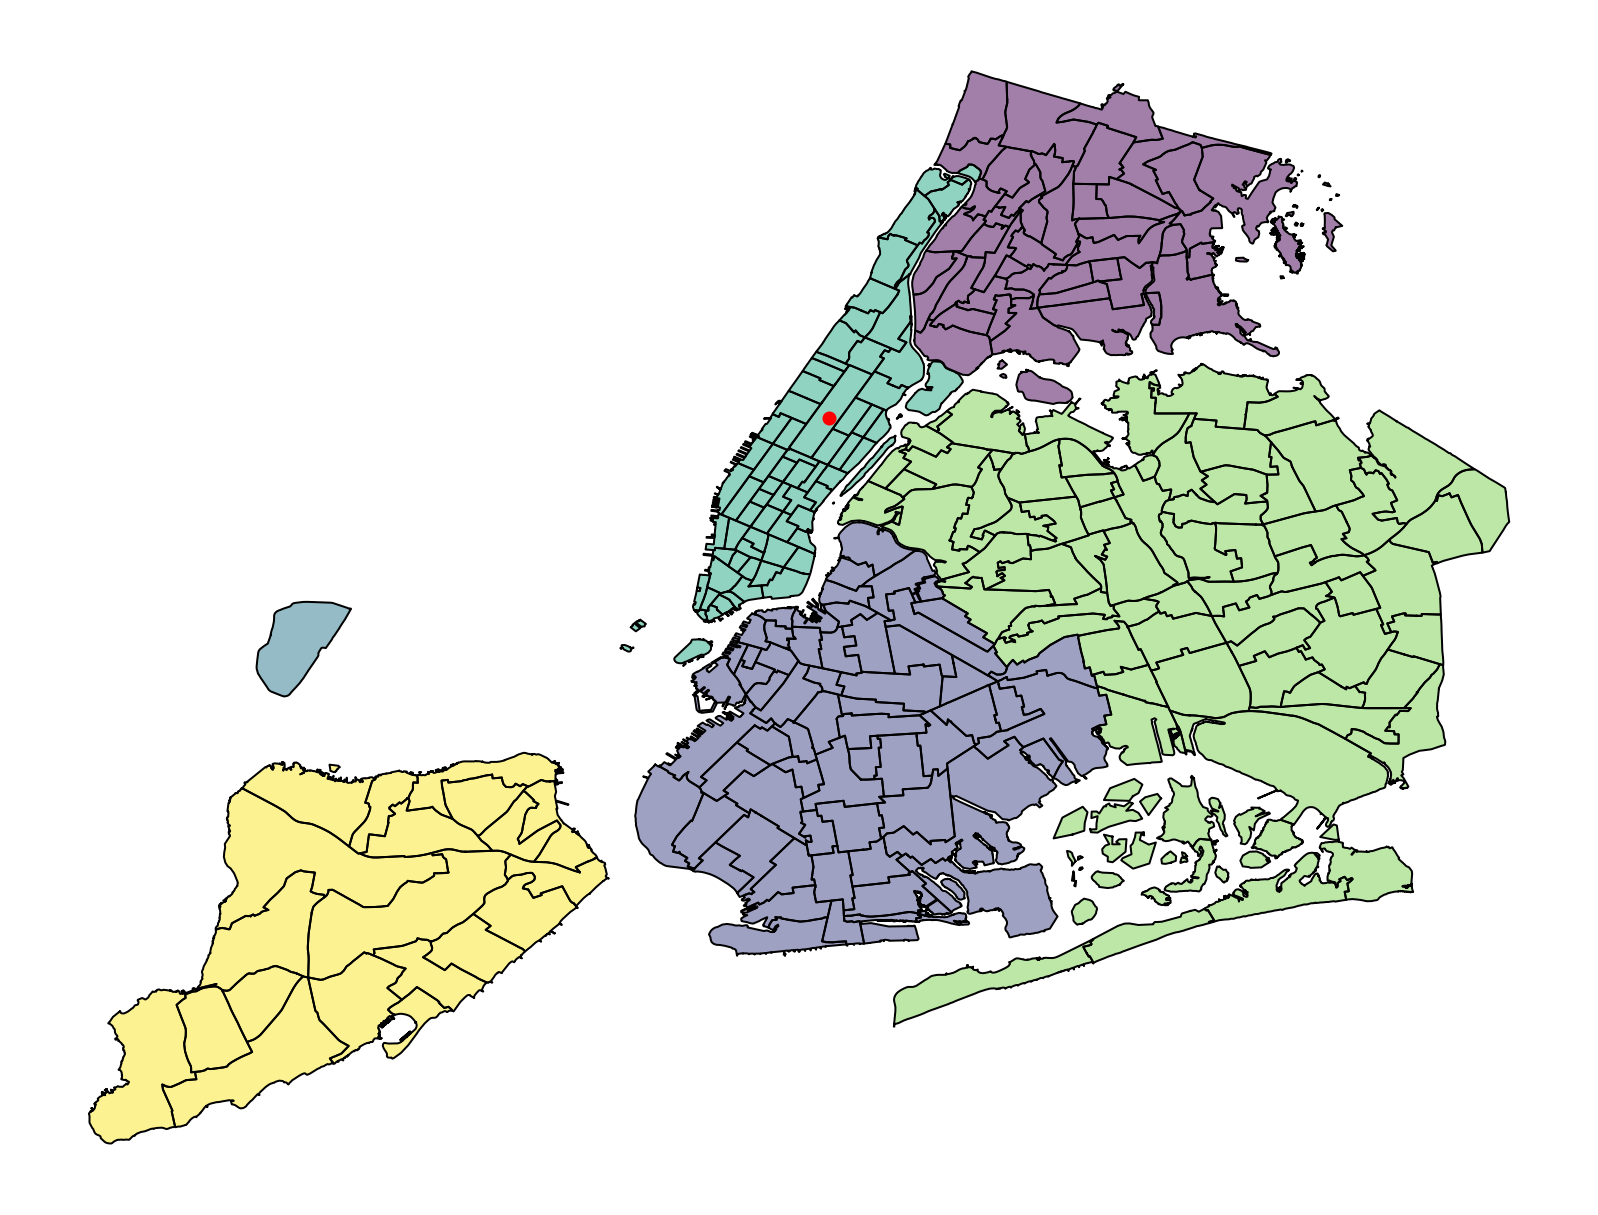

In [79]:
# <!-- collapse=True -->
df.plot(column='borough', cmap=plt.cm.viridis)

# Plot a point in central park
plt.plot(-73.966, 40.78, 'o', color='red')

plt.gcf().set_size_inches(14, 14)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.gca().set_frame_on(False)

This is a familiar map of New York, with 262 taxi districts shown, colored by the borough they belong to. I have added a random point (-73.966˚E, 40.78˚N), which happens to fall in the middle of Central Park. Assigning a point as within a taxi zone is something humans can do easily, but on a computer it requires solving the [point in polygon problem](https://en.wikipedia.org/wiki/Point_in_polygon). Luckily the [Shapely](http://toblerity.org/shapely/project.html) library provides an easy interface to such geometric operations in Python. But, point in polygon is computationally expensive, and using the Shapely library on 2.4 billion (latitude, longitude) pairs to assign taxi zones as in the NYC Taxi Dataset would take a modern single core cpu about four years. To speed this up, we calculate the bounding boxes for each taxi zone, which looks like:

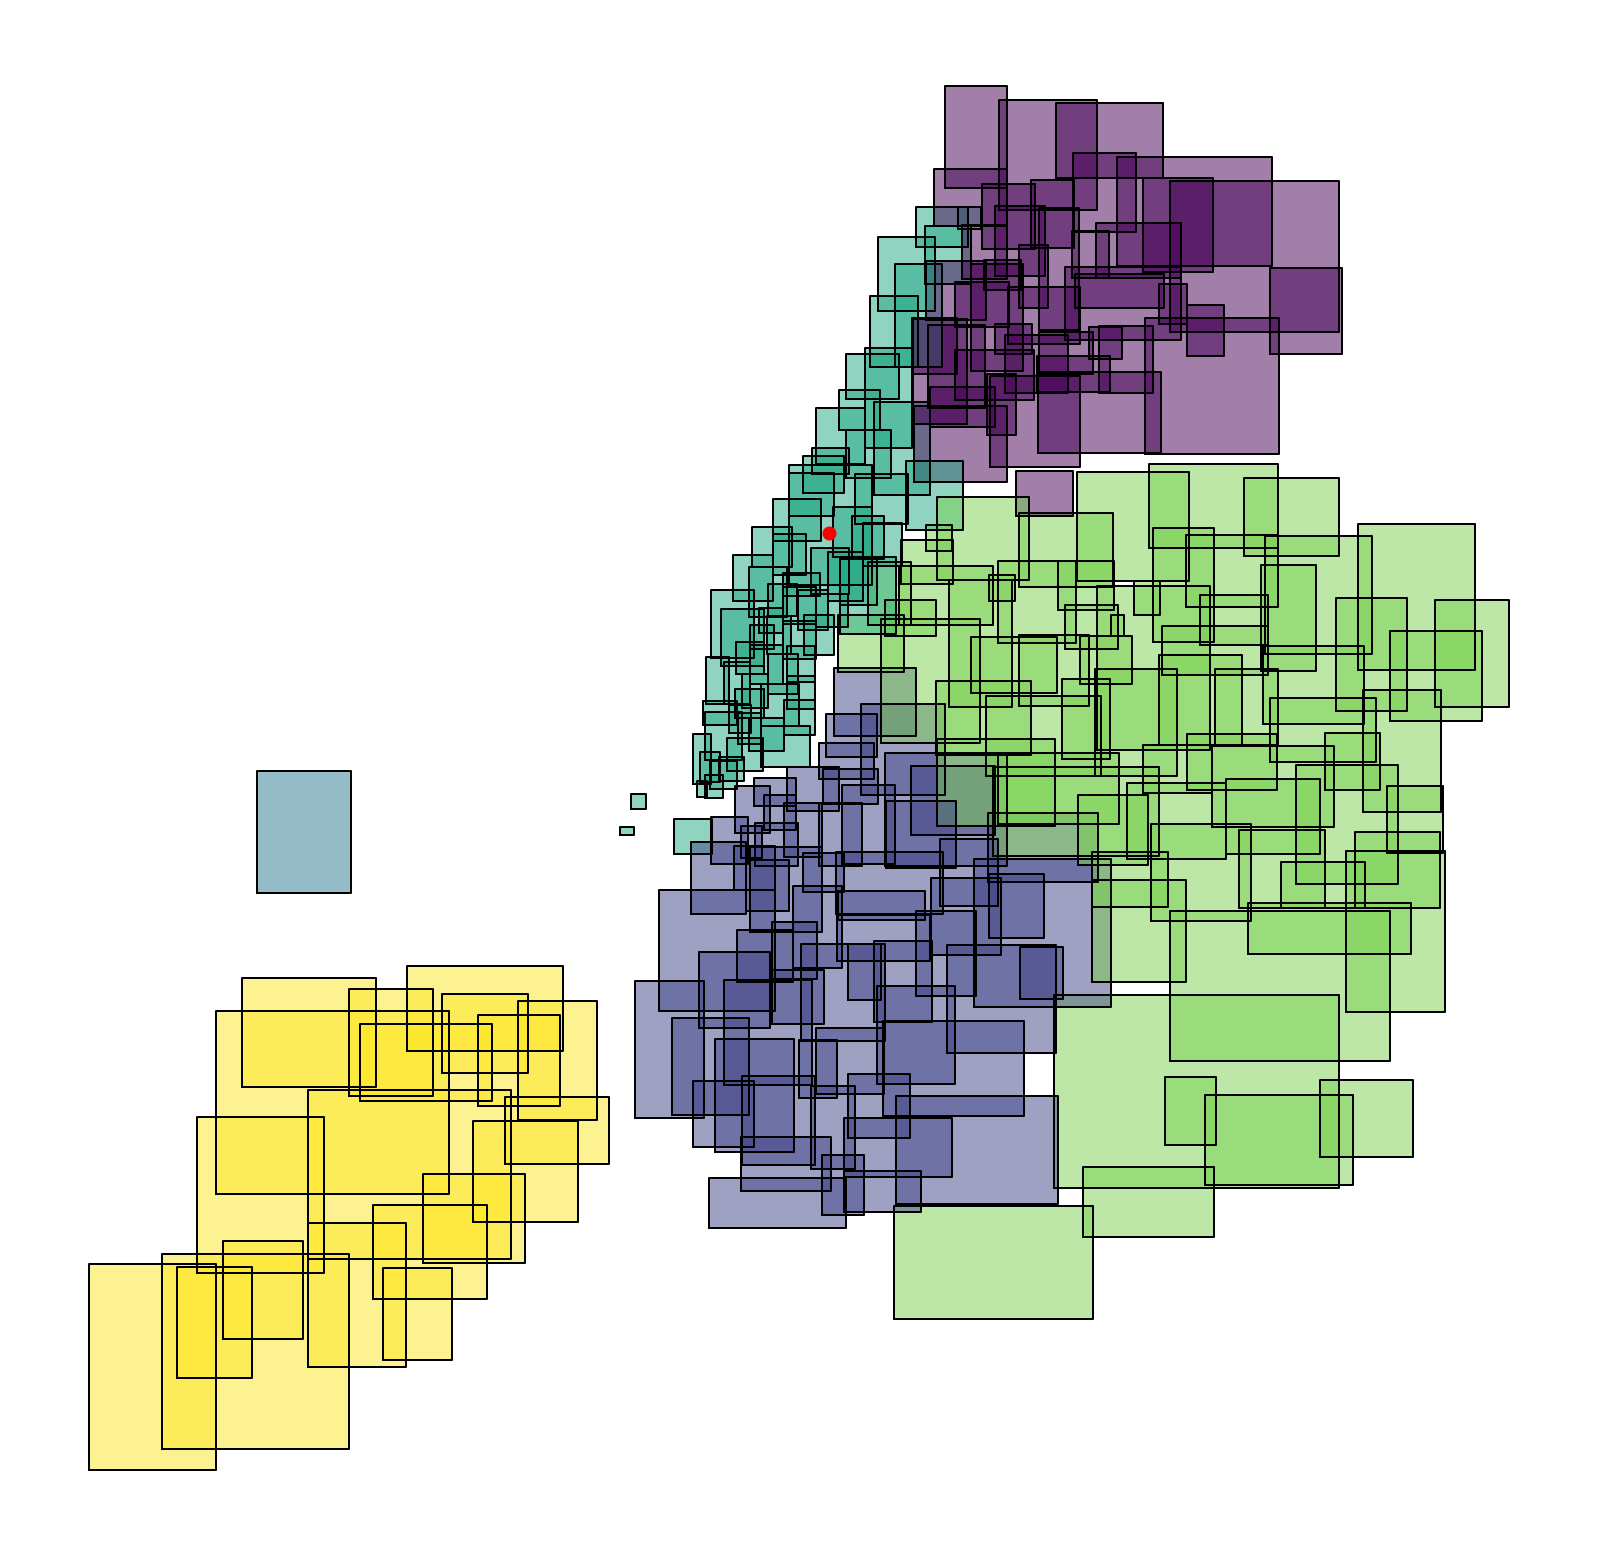

In [80]:
# <!-- collapse=True -->
df2 = df.copy()
df2['geometry'] = df.geometry.envelope

df2.plot(column="borough", cmap=plt.cm.viridis, ax=plt.gca(), alpha=0.5)
plt.plot(-73.966, 40.78, 'o', color='red')
plt.gcf().set_size_inches(14, 14)

ax = plt.gca()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

Now, given a (longitude, latitude) coordinate pair, bounding boxes that contain that pair can be efficiently calculated with an [R-tree](https://en.wikipedia.org/wiki/R-tree). Only the polygons (taxi zones) that have bounding boxes that contain the coordinate pair need to be examined, and then the point in Polygon is solved for those (hopefully) few taxi zones. This reduces computation by a factor of about 100-1000. This process, assigning coordinate pairs to taxi zones is one example of a spatial join. [Geopandas](http://geopandas.org) provides a nice interface to efficient spatial joins in Python, and it takes care of calculating bounding boxes and R-trees for you, as this snippet shows.

In [81]:
gpd.sjoin(gpd.GeoDataFrame(crs={'init': 'epsg:4326'}, geometry=[Point(-73.966, 40.78)]), 
          df,
          how='left', op='within')

,geometry,index_right,LocationID,borough,zone
0,POINT (-73.96599999999999 40.78),42,43,Manhattan,Central Park


This does the merge for a single point (drawn in red) on maps above, and correctly identifies it in Central Park

## Part 2 : Spatial Joins at scale using Dask

In my NYC transit project, I download and process the Taxi dataset. Here I load up a single file from the taxi dataset (May 2016) into Dask. 

In [144]:
# <!-- collapse=True -->
!wget --quiet --continue 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-05.csv'

trips = dd.read_csv('yellow_tripdata_2016-05.csv')
trips = trips[('tpep_pickup_datetime tpep_dropoff_datetime pickup_longitude'
        ' pickup_latitude dropoff_longitude dropoff_latitude').split()]
trips.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,2016-05-01 00:00:00,2016-05-01 00:17:31,-73.985901,40.768040,-73.983986,40.730099
1,2016-05-01 00:00:00,2016-05-01 00:07:31,-73.991577,40.744751,-73.975700,40.765469
2,2016-05-01 00:00:00,2016-05-01 00:07:01,-73.993073,40.741573,-73.980995,40.744633
3,2016-05-01 00:00:00,2016-05-01 00:19:47,-73.991943,40.684601,-74.002258,40.733002
4,2016-05-01 00:00:00,2016-05-01 00:06:39,-74.005280,40.740192,-73.997498,40.737564


I plot the start (red) and end (blue) locations of the first trip, ending in the East Village.

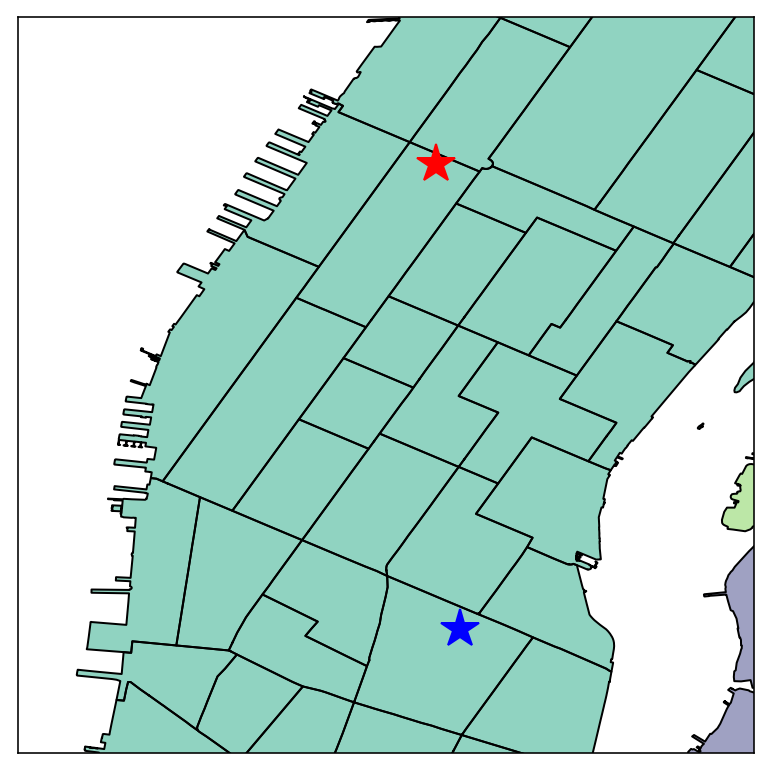

In [145]:
# <!-- collapse=True -->
df.plot(column='borough', cmap=plt.cm.viridis)

pickup_location = trips.head(1).ix[:,2:4].values.squeeze().tolist()
dropoff_location = trips.head(1).ix[:,4:6].values.squeeze().tolist()
# Plot a point in central park
plt.plot(*pickup_location, marker='*', markersize=20, color='red')
plt.plot(*dropoff_location, marker='*', markersize=20, color='blue')

plt.xlim(-74.02, -73.96)
plt.ylim(40.72, 40.78)

plt.tight_layout()

plt.gcf().set_size_inches(6, 6)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
# plt.gca().set_frame_on(False)

Create extra columns for taxi zones.

In [146]:
trips['pickup_taxizone_id'] = np.nan
trips['dropoff_taxizone_id'] = np.nan
trips.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_taxizone_id,dropoff_taxizone_id
0,2016-05-01 00:00:00,2016-05-01 00:17:31,-73.985901,40.768040,-73.983986,40.730099,NaN,NaN
1,2016-05-01 00:00:00,2016-05-01 00:07:31,-73.991577,40.744751,-73.975700,40.765469,NaN,NaN
2,2016-05-01 00:00:00,2016-05-01 00:07:01,-73.993073,40.741573,-73.980995,40.744633,NaN,NaN
3,2016-05-01 00:00:00,2016-05-01 00:19:47,-73.991943,40.684601,-74.002258,40.733002,NaN,NaN
4,2016-05-01 00:00:00,2016-05-01 00:06:39,-74.005280,40.740192,-73.997498,40.737564,NaN,NaN


In [147]:
def assign_taxi_zones(df, lon_var, lat_var, locid_var):
    """Joins DataFrame with Taxi Zones shapefile.
    This function takes longitude values provided by `lon_var`, and latitude
    values provided by `lat_var` in DataFrame `df`, and performs a spatial join
    with the NYC taxi_zones shapefile. 
    The shapefile is hard coded in, as this function makes a hard assumption of
    latitude and longitude coordinates. It also assumes latitude=0 and 
    longitude=0 is not a datapoint that can exist in your dataset. Which is 
    reasonable for a dataset of New York, but bad for a global dataset.
    Only rows where `df.lon_var`, `df.lat_var` are reasonably near New York,
    and `df.locid_var` is set to np.nan are updated. 
    Parameters
    ----------
    df : pandas.DataFrame or dask.DataFrame
        DataFrame containing latitudes, longitudes, and location_id columns.
    lon_var : string
        Name of column in `df` containing longitude values. Invalid values 
        should be np.nan.
    lat_var : string
        Name of column in `df` containing latitude values. Invalid values 
        should be np.nan
    locid_var : string
        Name of column in `df` containing taxi_zone location ids. Rows with
        valid, nonzero values are not overwritten. 
    """
    
    # Make a copy of the relevant variables, 
    # create a flag whether a location needs to be 
    # assigned 
    localdf = df[[lon_var, lat_var, locid_var]].copy()
    localdf[lon_var] = localdf[lon_var].fillna(value=0.)
    localdf[lat_var] = localdf[lat_var].fillna(value=0.)
    localdf['replace_locid'] = (localdf[locid_var].isnull()
                                & (localdf[lon_var] != 0.)
                                & (localdf[lat_var] != 0.))

    if (np.any(localdf['replace_locid'])):
        shape_df = gpd.read_file('../shapefiles/taxi_zones.shp')
        shape_df.drop(['OBJECTID', "Shape_Area", "Shape_Leng", "borough", "zone"],
                      axis=1, inplace=True)
        
        shape_df = shape_df.to_crs({'init': 'epsg:4326'})

        try:
            local_gdf = gpd.GeoDataFrame(
                localdf, crs={'init': 'epsg:4326'},
                geometry=[Point(xy) for xy in
                          zip(localdf[lon_var], localdf[lat_var])])

            local_gdf = gpd.sjoin(
                local_gdf, shape_df, how='left', op='within')

            local_gdf.LocationID.values[~local_gdf.replace_locid] = (
                (local_gdf[locid_var])[~local_gdf.replace_locid]).values

            return local_gdf.LocationID.rename(locid_var)
        except ValueError as ve:
            print(ve)
            print(ve.stacktrace())
            return df[locid_var]
    else:
        return df[locid_var]

In [148]:
trips['start_taxizone_id'] = trips.map_partitions(
    assign_taxi_zones, "pickup_longitude", "pickup_latitude",
    "pickup_taxizone_id", meta=('pickup_taxizone_id', np.float64))
trips['end_taxizone_id'] = trips.map_partitions(
    assign_taxi_zones, "dropoff_longitude", "dropoff_latitude",
    "dropoff_taxizone_id", meta=('dropoff_taxizone_id', np.float64))

In [151]:
trips.get_partition(0).compute()

/home/shekhar/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:54: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/shekhar/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:54: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


,tpep_pickup_datetime,tpep_dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_taxizone_id,dropoff_taxizone_id,start_taxizone_id,end_taxizone_id
0,2016-05-01 00:00:00,2016-05-01 00:17:31,-73.985901,40.768040,-73.983986,40.730099,NaN,NaN,NaN,NaN
1,2016-05-01 00:00:00,2016-05-01 00:07:31,-73.991577,40.744751,-73.975700,40.765469,NaN,NaN,NaN,NaN
2,2016-05-01 00:00:00,2016-05-01 00:07:01,-73.993073,40.741573,-73.980995,40.744633,NaN,NaN,234.0,170.0
3,2016-05-01 00:00:00,2016-05-01 00:19:47,-73.991943,40.684601,-74.002258,40.733002,NaN,NaN,25.0,249.0
4,2016-05-01 00:00:00,2016-05-01 00:06:39,-74.005280,40.740192,-73.997498,40.737564,NaN,NaN,158.0,249.0
5,2016-05-01 00:00:00,2016-05-01 00:05:19,-73.979294,40.755764,-73.988014,40.758469,NaN,NaN,161.0,230.0
6,2016-05-01 00:00:00,2016-05-01 00:15:43,-73.981544,40.780739,-73.937805,40.855343,NaN,NaN,239.0,243.0
7,2016-05-01 00:00:00,2016-05-01 00:06:31,-73.987198,40.750507,-73.980797,40.767826,NaN,NaN,164.0,43.0
8,2016-05-01 00:00:00,2016-05-01 00:00:00,-74.001610,40.740990,-73.981079,40.730675,NaN,NaN,90.0,79.0
9,2016-05-01 00:00:00,2016-05-01 00:00:00,-74.013855,40.714119,-73.994049,40.761452,NaN,NaN,13.0,48.0
